# Data preparation

In this tutorial, we introduce how to use ``EpiPack`` together with external preprocessing tools to generate the peak embedding and gene score matrix required for building a mappable reference model with ``PEIVI`` and for subsequent query mapping. We will use the 10X Genomics PBMC dataset as an example.

In [1]:
## load epipack package

# !pip install --upgrade epipackpy
import scanpy as sc
import numpy as np
import pandas as pd

import epipackpy as epk
print(epk.__version__)

1.0.1dev4


### 1. Create gene score matrix

To construct the **gene score matrix**, we recommend using either [**snapATAC2**](https://scverse.org/SnapATAC2/index.html) or [**Signac**](https://stuartlab.org/signac/), both of which provide efficient and flexible workflows for generating gene activity scores from scATAC-seq data. While **ArchR** can also be used for this purpose, its flexibility is somewhat lower compared to snapATAC2 and Signac.  

#### Signac
We put the R code for quality control and gene activity score generation as below, more details can be found on their website.

In [ ]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)

counts <- Read10X_h5(filename = "atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_pbmc_5k_nextgem_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = 'atac_pbmc_5k_nextgem_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)


annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
Annotation(pbmc) <- annotations

gene.activities <- GeneActivity(pbmc)
write.csv(t(gene.activities),file = "pbmc_10k_geneactivity.csv", row.names = T, col.names = T)

The ``genescore.csv`` file can be loaded by ``pd.read_csv`` in Python.

#### snapATAC2

In [2]:
import snapatac2 as snap
print(snap.__version__)

2.7.1


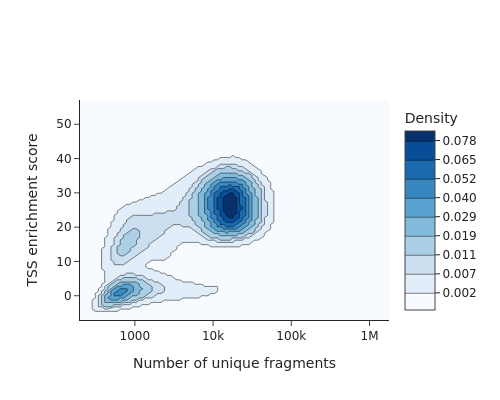

In [ ]:
data = snap.pp.import_data(
    "/data/pbmc_batch/pbmc_5k_nextgem/atac_pbmc_5k_nextgem_fragments.tsv.gz",
    chrom_sizes=snap.genome.hg38,
    file="PBMC.h5ad",  # Optional
    sorted_by_barcode=False,
)
snap.metrics.tsse(data, snap.genome.hg38)
snap.pl.tsse(data, interactive=False)

In [4]:
snap.pp.filter_cells(data, min_tsse=10, min_counts=5000)
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38)
gene_matrix

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 4565 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'

### 2. Create peak embedding

After obtaining the **gene score matrix**, the next step is to generate the **peak embeddings** using the `epipack` toolkit.  

First, we need to **load the peak file** (e.g., the BED file containing peak regions) and ensure that the cells are aligned based on the quality control results from either ``snapATAC2`` or ``Signac``. This alignment guarantees that the peaks and cell barcodes used for embedding are consistent with those used in the gene score matrix.

In [ ]:
peak_1 = epk.dt.read_10x_h5("data/pbmc_batch/pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.h5")
peak_1

AnnData object with n_obs × n_vars = 4623 × 135377
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
###align cells between genescore and peak file

common_cells = gene_matrix.obs_names.intersection(peak_1.obs_names)
peak_1= peak_1[common_cells, :]
gene_matrix = gene_matrix[common_cells,:]

After that, ``EpiPack peak encoder`` can be used to generate peak embedding. All peaks should be converted to 0-1 binary format.

In [18]:
peak_1 = epk.dt.make_binary(peak_1)

Before training the binary autoencoder, we follow the same peak filtering process as PeakVI to filter out rarely detected peaks, to make the training faster.

In [19]:
print("# regions before filtering:", peak_1.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(peak_1.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(peak_1, min_cells=min_cells)

print("# regions after filtering:", peak_1.shape[-1])

# regions before filtering: 135377
# regions after filtering: 38749


#### Model training

 we will start training the binary autoencoder model to obtain batch-specific latent embedding. If the peak matrix is in dense matrix format, we need to input ``anndata.X.todense()`` to the model.

In [20]:
# model initialization
pretrain_peak_model = epk.ml.Peak_Model(count_enhancer=peak_1.X.todense())

# model training
pretrain_peak_model.train_model(nepochs=150)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Model intialization completed.


Epochs: 100%|██████████| 150/150 [02:36<00:00,  1.04s/it, loss_val=9.55e+3]


#### get the peak embedding

We can extract the latent embedding and save it to the h5ad file. **For the other peak files, repeat the process and save the integrated gene score matrix into one h5ad file.**

In [22]:
peak_1.obsm['Z_epipack'] = pretrain_peak_model.get_z().detach().numpy()

In [ ]:
peak_1.write_h5ad("EDIT_YOUR_PATH")
gene_matrix.write_h5ad("EDIT_YOUR_PATH")